In [1]:
import time

In [2]:
from scipy.special import digamma
from numpy.linalg import inv
from numpy import log
import numpy as np

import matplotlib.pyplot as plt

from multivariate_util import *

In [3]:
def log_likelihood():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -.5*n*p*log(2 * np.pi) -.5*n*log(np.linalg.det(cov)) - .5 * sum(u_)

In [4]:
def m_step(X, mu, cov, u, tau):
    mu_ = (tau * u * X).sum(axis=0) / (tau * u).sum()
    
    cov_ = np.array([[0,0], [0,0]], dtype=np.float32)
    for idx, delta in enumerate(X - mu_):
        delta = delta.reshape(-1, 1)
        cov_ += (tau[idx] * u[idx] * delta).dot(delta.T)

    cov_ /= tau.sum()
    
    if mu_[0] == np.nan:
        print mu_
    
    return mu_, cov_

###### Finding degrees of freedom for a single mixture
$$
-\psi \bigg(\frac{v}{2} \bigg) + log \bigg(\frac{v}{2} \bigg) + 1 + \psi \bigg(\frac{v^{(k)} + p}{2} \bigg) - log \bigg(\frac{v^{(k)} + p}{2} \bigg) + \frac{1}{n}\sum_{j=1}^n \bigg[ log(u_j^{(k)}) - u_j^{(k)} \bigg] = 0
$$

**Source** <br />
* G. J. McLachlan, T. Krishnan; The EM Algorithm and Extensions; 5.8.2; pg. 177.

###### Finding degrees of freedom with n mixtures
$$
-\psi \bigg(\frac{v_i}{2} \bigg) + log \bigg(\frac{v_i}{2} \bigg) + 1 + \psi \bigg(\frac{v_i^{(k)} + p}{2} \bigg) - log \bigg(\frac{v_i^{(k)} + p}{2} \bigg) + \
\frac{1}{n_i^{(k)}}\sum_{j=1}^n \tau_{ij}^{(k)} \bigg[ log(u_{ij}^{(k)}) - u_{ij}^{(k)} \bigg] = 0
$$
Where
$$
n_i^{(k)} = \Sigma_{j=1}^n \tau_{ij}^{(k)}
$$

**Source**<br />
* D. Peel, G. J. McLachlan; Robust mixture modelling using the t distribution. Statistics and Computing (2000) 10, 339-348.
    
    7 M-Step; pg. 343.

In [5]:
def find_df(v, p, u, tau):
    return -digamma(v/2.) + log(v/2.) + (tau * (log(u) - u)).sum()/tau.sum() + 1 + (digamma((v+p)/2.)-log((v+p)/2.))
u_test   = np.array([[1,1], [2,2], [3,3]])
tau_test = np.array([[4,4], [5,5], [6,6]])
find_df(1, 2, u_test, tau_test)

0.43854835365244849

In [6]:
def get_random(X):
    size = len(X)
    idx = np.random.choice(range(size))
    return X[idx]

## Expectation Maximization with Mixtures
Implementation of a mixture model using the t distribution.
#### Source
1. D. Peel, G. J. McLachlan; Robust mixture modelling using the t distribution. Statistics and Computing (2000) 10, 339-348.

### Generating a sample
I'll generate two samples with distinct parameters and merge them into one.

In [7]:
actual_mu01  = [-.2, .45]
actual_cov01 = [[.40, 0], [.7, 1.55]]
actual_df01  = 27

In [8]:
actual_mu02  = [.9, -.5]
actual_cov02 = [[1.5, 0.7], [0, 0.5]]
actual_df02  = 47

In [9]:
size = 300

In [10]:
x01 = multivariate_t_rvs(m=actual_mu01, S=actual_cov01, df=actual_df01, n=size)
x02 = multivariate_t_rvs(m=actual_mu02, S=actual_cov02, df=actual_df02, n=size)

In [11]:
X = np.concatenate([x01, x02])
X.shape

(600L, 2L)

### Plotting the sample with actual parameters

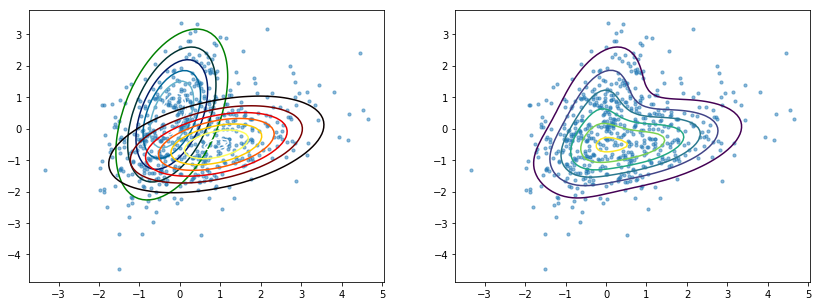

In [12]:
xmin, xmax = min(X.T[0]), max(X.T[0])
ymin, ymax = min(X.T[1]), max(X.T[1])

x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy = np.column_stack([x.ravel(),y.ravel()])
xy.shape

t01 = multivariate_t(actual_mu01, actual_cov01, actual_df01)
t02 = multivariate_t(actual_mu02, actual_cov02, actual_df02)

z01 = []
z02 = []
for _ in xy:
    z01.append(t01.pdf(_.reshape(1, -1)))
    z02.append(t02.pdf(_.reshape(1, -1)))
z01 = np.reshape(z01, x.shape)
z02 = np.reshape(z02, x.shape)

# Plotting
fig = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01, cmap='ocean')
plt.contour(x, y, z02, cmap='hot')

plt.subplot(122)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01+z02)

fig.savefig('draft05 - actual.png')

plt.show()

### Estimating parameters

In [13]:
n_iter = 50 # number of iterations

# guessing mixture 01
mu01  = get_random(X)
cov01 = np.cov(X.T.copy())
# known variables mix01
df01  = 4
p01 = 2

# guessing mixture 02
mu02  = get_random(X)
cov02 = np.cov(X.T.copy())
# known variables mix 02
df02 = 4
p02 = 2

# guessing the pi parameter
pi = .5

t01 = multivariate_t(mu01, cov01, df01)
t02 = multivariate_t(mu02, cov02, df02)

start = time.time()
for i in range(n_iter):
    # E-step: Calculating tau
    wp1 = t01.pdf(X) * pi
    wp2 = t02.pdf(X) * (1 - pi)
    wp_total = wp1 + wp2

    wp1 /= wp_total; wp1 = wp1.reshape(-1, 1)
    wp2 /= wp_total; wp2 = wp2.reshape(-1, 1)

    # E-Step: Calculating u
    u01 = []
    for delta in X-mu01:
        u01.append(delta.dot(inv(cov01)).dot(delta))
    u01 = np.array(u01)
    u01 = (df01 + p01)/(df01 + u01); u01 = u01.reshape(-1, 1)

    u02 = []
    for delta in X-mu02:
        u02.append(delta.dot(inv(cov02)).dot(delta))
    u02 = np.array(u02)
    u02 = (df02 + p02)/(df02 + u02); u02 = u02.reshape(-1, 1)

    # CM-Step 01
    mu01, cov01 = m_step(X, mu01, cov01, u01, wp1)
    mu02, cov02 = m_step(X, mu02, cov02, u02, wp2)
    
    # E-Step 02
    u01 = []
    for delta in X-mu01:
        u01.append(delta.dot(inv(cov01)).dot(delta))
    u01 = np.array(u01)
    u01 = (df01 + p01)/(df01 + u01); u01 = u01.reshape(-1, 1)

    u02 = []
    for delta in X-mu02:
        u02.append(delta.dot(inv(cov02)).dot(delta))
    u02 = np.array(u02)
    u02 = (df02 + p02)/(df02 + u02); u02 = u02.reshape(-1, 1)
    
    # CM-Step 02
    ## Finding mix01 degrees of freedom
    v01 = 0
    my_range = np.arange(df01, df01+3, .01)
    for _ in my_range:
        solution = find_df(_, p01, u01, wp1)
        if solution < 0+1e-4 and solution > 0-1e-4:
            v01 = _
            break
    ## Finding mix01 degrees of freedom
    v02 = 0
    my_range = np.arange(df02, df02+3, .01)
    for _ in my_range:
        solution = find_df(_, p02, u02, wp2)
        if solution < 0+1e-4 and solution > 0-1e-4:
            v02 = _
            break
    
    # Assigning parameters
    t01.mu = mu01; t01.sigma = cov01
    t02.mu = mu02; t02.sigma = cov02
    
    df01 = v01; df02 = v02
    
    pi = wp1.sum()/len(wp1)

print 'elapsed time: %s' % (time.time() - start)
print 'pi: {0:4.06}'.format(pi)
print 'mu01: {0}; mu02: {1}'.format(mu01, mu02)
print 'cov01\n%s' % cov01
print 'cov02\n%s' % cov02
print 'df01: %.6f; df02: %.6f;' % (df01, df02)

elapsed time: 10.9270000458
pi: 0.402854
mu01: [ 0.97159944 -0.45423017]; mu02: [-0.11795076  0.15907417]
cov01
[[ 1.48095632  0.48002473]
 [ 0.48002473  0.75578219]]
cov02
[[ 0.63843542  0.37537971]
 [ 0.37537971  1.41771543]]
df01: 14.530000; df02: 15.680000;


In [14]:
xmin, xmax = min(X.T[0]), max(X.T[0])
ymin, ymax = min(X.T[1]), max(X.T[1])

In [15]:
x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy = np.column_stack([x.ravel(),y.ravel()])
xy.shape

t01 = multivariate_t(mu01, cov01, df01)
t02 = multivariate_t(mu02, cov02, df02)

z01 = []
z02 = []
z03 = []
for _ in xy:
    _ = _.reshape(1, -1)
    z01.append(t01.pdf(_))
    z02.append(t02.pdf(_))
    z03.append(pi*t01.pdf(_) + (1-pi)*t02.pdf(_))
z01 = np.reshape(z01, x.shape)
z02 = np.reshape(z02, x.shape)
z03 = np.reshape(z03, x.shape)

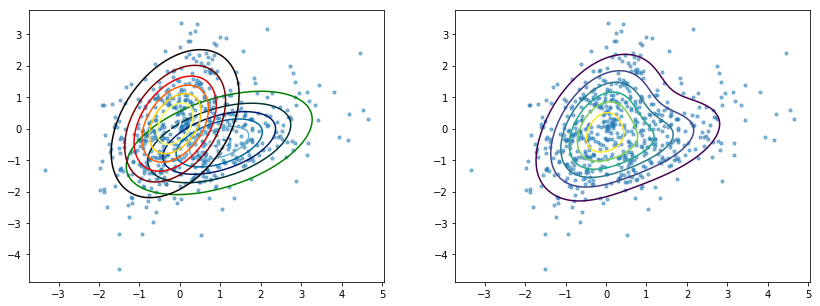

In [16]:
fig = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z01, cmap='ocean')
plt.contour(x, y, z02, cmap='hot')

plt.subplot(122)
plt.scatter(X.T[0], X.T[1], s=10, alpha=.5)
plt.contour(x, y, z03)

fig.savefig('draft05 - estimated.png')

plt.show()